In [1]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import ot
import csv

os.chdir('/home/baly/projects/linear_opt')

from lib.lib_lopt import *
from lib.geodesic import *
from lib.tools import *

/tmp/ipykernel_3267990/3167858300.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_list=np.asarray(X_list)


data_0
data_0.5
data_0.75
save data


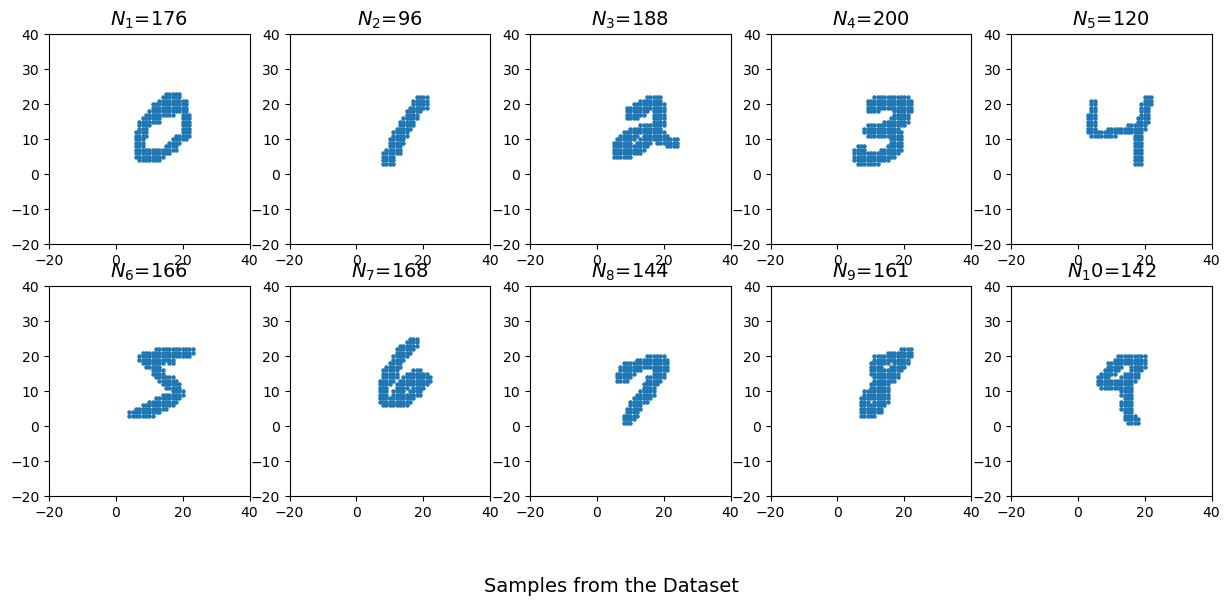

done


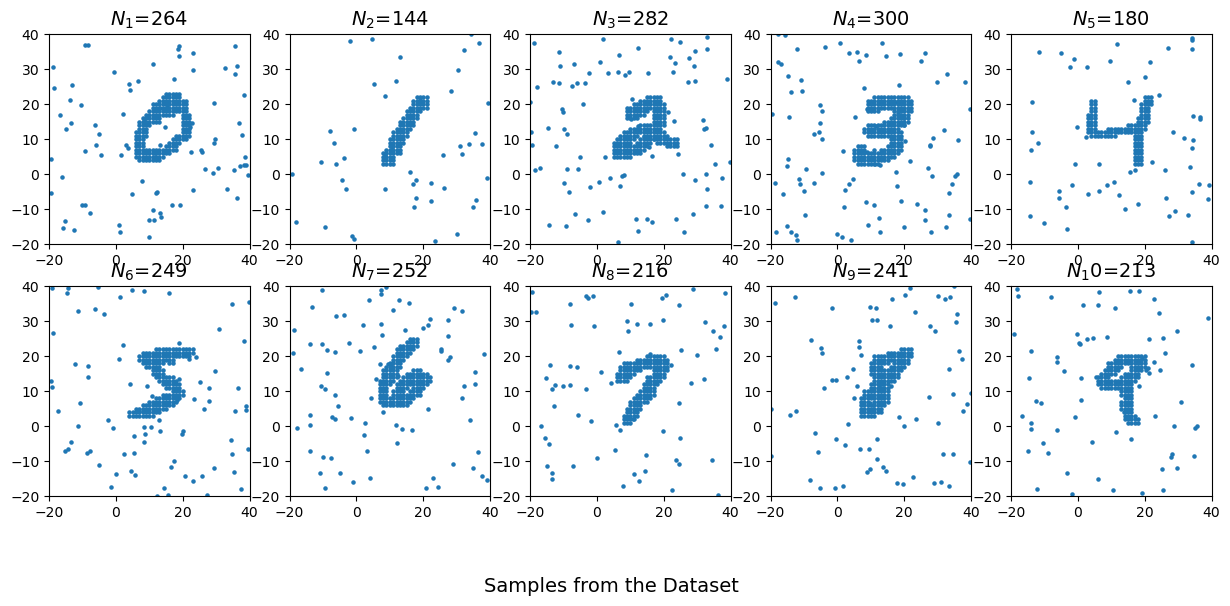

done


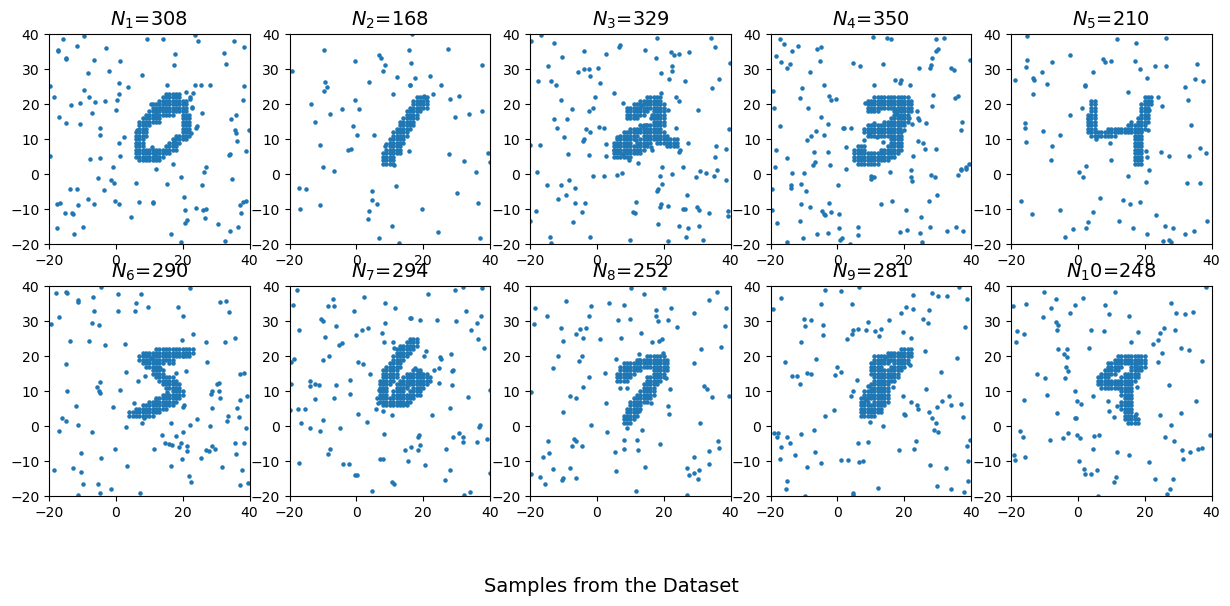

done


In [2]:
# load data, and add noise 

data0=torch.load('experiment/pca/data/MNIST_noP.pt')

data_list={}
data_list['data_0']=data0
per1=0.5
per2=0.75

X0_list,label_list=data0[0],data0[1]
label_list=np.array(label_list)
M=len(X0_list)
for per in [0,per1,per2]:
    X_list=list()
    for i in range(M):
        Xi=X0_list[i]
        N,d=Xi.shape
        n_noise=int(per*N)
        noise_i=np.random.uniform(low=[-20,-20],high=[40,40],size=(n_noise,d))
        Xi_noise=np.concatenate((Xi,noise_i))
    
        X_list.append(Xi_noise)
    X_list=np.asarray(X_list)
    data_list['data_'+str(per)]=(X_list,label_list)
torch.save(data_list,'experiment/pca/data/MNIST_noise.pt')

for key in data_list:
    print(key)
print('save data')

for per in [0,per1,per2]:
    k=5
    X_list,label_list=data_list['data_'+str(per)]
    fig,ax=plt.subplots(2,5,figsize=(3*5,3*2))
    ind=0
    for i in range(10):
        
        X=X_list[i*300]
        ax[int(i/5),i%5].scatter(X[:,0],X[:,1],s=5)
        ax[int(i/5),i%5].set_title(r'$N_%d$=%d'%(i+1,X.shape[0]),fontsize=14)
        ax[int(i/5),i%5].set_xlim(-20,40)
        ax[int(i/5),i%5].set_ylim(-20,40)
    fig.text(0.5, -0.05, 'Samples from the Dataset', ha='center',fontsize=14)
    plt.show()
    print('done')
    

In [3]:
# choose 3 labels and save the data 
label_select=[0,1,3]
data_list=torch.load('experiment/pca/data/MNIST_noise.pt')
MNIST_select_noise={}
for per in [0,per1,per2]:
    X_list,label_list=data_list['data_'+str(per)]
    index_list=np.concatenate([np.arange(300*i,300*(i+1)) for i in label_select])
    MNIST_select_noise['data_'+str(per)]=(X_list[index_list],label_list[index_list])
torch.save(MNIST_select_noise,'experiment/pca/data/MNIST_select_noise.pt')
label_list1=label_list[index_list]

In [5]:
label_select=[0,1,3]
data_list=torch.load('experiment/pca/data/MNIST_select_noise.pt')

# computer barycenter 
N=10
N0=300
X_list,label_list=data_list['data_0']
sample_list=sampling(X_list,N,N0,len(label_select))
N_list=np.zeros(len(sample_list),dtype=np.int64)
for i in range(len(sample_list)):
    N_list[i]=sample_list[i].shape[0]
N0=int(np.mean(N_list))+30
p0=np.ones(N0)/N0


p_list=[]
for i in range(len(sample_list)):
    p_list.append(np.ones(N_list[i])/N_list[i])

X0_init=np.random.uniform([5,5],[25,25],(N0,2))
weights=np.ones(len(sample_list))/len(sample_list)
X0=lot_barycenter(sample_list,p_list,X0_init,p0,weights)

print('done')


done


In [6]:
# get lot embedding: 
data_list=torch.load('experiment/pca/data/MNIST_select_noise.pt')
lot_embed={}
lot_embed['X0']=X0
lot_embed['p0']=p0
for per in [0,per1,per2]:
    X_list,label_list=data_list['data_'+str(per)]
    U_list=list()
    for i in range(len(X_list)):
        Xi=X_list[i]
        pi=np.ones(Xi.shape[0])/Xi.shape[0]
        Ui=lot_embedding(X0,Xi,p0,pi)
        U_list.append(Ui)
    U_list=np.array(U_list)
    
    lot_embed[str(per)+'_U_list']=U_list
    
torch.save(lot_embed,'experiment/pca/result/lot_embed.pt')


    

In [7]:
# get lopt embedding: 
data_list=torch.load('experiment/pca/data/MNIST_select_noise.pt')
lopt_embed={}
lopt_embed['X0']=X0
lopt_embed['p0']=p0
Lambda=40.0
for per in [0,per1,per2]:
    X_list0,label_list0=data_list['data_0']
    X_list,label_list=data_list['data_'+str(per)]
    U_list=list()
    p_hat_list=list()
    for i in range(len(X_list)):
        Xi=X_list[i]
        Ni0=X_list0[i].shape[0]
        pi=np.ones(Xi.shape[0])/Ni0
        Ui,pi_hat,Mi=lopt_embedding(X0,Xi,p0,pi,Lambda)
        U_list.append(Ui)
        p_hat_list.append(pi_hat)
    U_list=np.array(U_list)
    p_hat_list=np.array(p_hat_list)
    lopt_embed[str(per)+'_U_list']=(U_list,p_hat_list)
    
torch.save(lopt_embed,'experiment/pca/result/lopt_embed.pt')

In [8]:
# test LOT
    
lot_embed=torch.load('experiment/pca/result/lot_embed.pt')
X0=lot_embed['X0']
p0=lot_embed['p0']
k=2
pca_lot={}
for per in [0,per1,per2]:
    U_list=lot_embed[str(per)+'_U_list']
    a,eig,V=PCA_numpy(U_list,k)
    pca_lot[str(per)]=(a,eig,V)
torch.save(pca_lot,'experiment/pca/result/pca_lot.pt')


        
        
        

NameError: name 'N' is not defined

In [ ]:
# test LOPT
lopt_embed=torch.load('experiment/pca/result/lopt_embed.pt')
X0=lopt_embed['X0']
p0=lopt_embed['p0']
k=2
pca_lopt={}
for per in [0,per1,per2]:
    U_list,p_hat_list=lopt_embed[str(per)+'_U_list']
    a,eig,V=PCA_numpy(U_list,k)
    pca_lopt[str(per)]=(a,eig,V)
torch.save(pca_lopt,'experiment/pca/result/pca_lopt.pt')



In [ ]:
# plot the result
pt=0.001
color_list=['blue','orange','green']
method_list=['lot','lopt']
for per in [0,per1,per2]:
    fig,ax=plt.subplots(1,2,figsize=(3*2,3*2))
    name='experiment/pca/result/pca_'+str(per)+'.pdf'
    for i in range(2):
        result=torch.load('experiment/pca/result/pca_'+method_list[i]+'.pt')
        a,eig,V=result[str(per)]
        for j in range(3):
            #label=None
            label=str(label_select[j])
            color=color_list[j]
            scatter_2d_sub(ax[i],a[300*(j):300*(j+1)],pt,xlim=None,ylim=None,color=color,marker='o',label=label)
    ax[0].set_ylabel(method_list[0].upper(),fontsize=18)        
    ax[1].set_ylabel(method_list[1].upper(),fontsize=18)
    plt.subplots_adjust(wspace=0, hspace=0)
    ax[0].legend(bbox_to_anchor=(1.02, 1.02),loc='upper right',fancybox=True, shadow=True, ncol=3,fontsize=8)
    #ax[1].legend(fancybox=True, shadow=True, ncol=2,fontsize=8)
    plt.savefig(name,dpi=200,format='pdf',bbox_inches='tight')
    
    plt.show()

    

In [ ]:
# plot the result
pt=0.001
color_list=['blue','orange','green']
method_list=['lot','lopt']
marker_list=['o','^','v']
fig,ax=plt.subplots(2,2,figsize=(3*2,3*2))
for (i,per) in enumerate([0,per2]):
    name='experiment/pca/result/pca_result.pdf'
    for j,method in enumerate(method_list):
        result=torch.load('experiment/pca/result/pca_'+method+'.pt')
        a,eig,V=result[str(per)]
        for (k,(color,marker)) in enumerate(zip(color_list,marker_list)):
            label=str(label_select[k])
            scatter_2d_sub(ax[i,j],a[300*(k):300*(k+1)],pt,xlim=None,ylim=None,color=color,marker=marker,label=label)
        if i==1:
            ax[i,j].set_xlabel(method.upper(),fontsize=18)
        if j==0:
            ax[i,j].set_ylabel(r'$\eta=%0.2f$'%(per),fontsize=18)
        
    plt.subplots_adjust(wspace=0, hspace=0)
    ax[0,1].legend(bbox_to_anchor=(1.02, 1.05),loc='upper right',fancybox=True, shadow=True, ncol=3,fontsize=11)
    #ax[1].legend(fancybox=True, shadow=True, ncol=2,fontsize=8)
plt.savefig(name,dpi=200,format='pdf',bbox_inches='tight')
    
plt.show()

    